In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Create a function to calculate ECDF given a column series
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y  

In [3]:
df = pd.read_csv('Sheffield.csv')

In [4]:
df.tail()

,yyyy,mm,tmax,tmin,af,rain,sun
1597,2016,2,7.8,2,5,68.6,96.1
1598,2016,3,9.1,2.9,2,87.2,98.6
1599,2016,4,11.6,3.8,1,65.8,154.9
1600,2016,5,16.9,7.9,0,58.2,164.5
1601,2016,6,18.8,11.1,0,130.4,106.5


In [5]:
mod = df.query('yyyy > 2000 and yyyy < 2015 and rain < 200')

In [6]:
rainfall = mod.rain

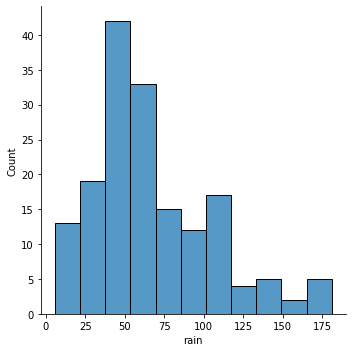

In [7]:
sns.displot(rainfall)

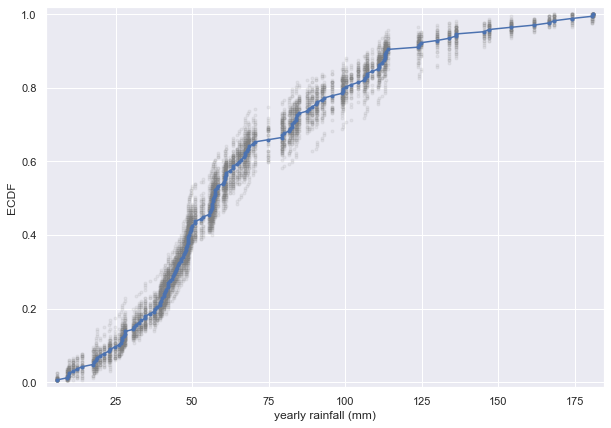

In [8]:
sns.set()
fig, ax = plt.subplots(figsize=(10,7))

for i in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

## Create a Bootstrap replicate function

In [9]:
# Bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [10]:
bs_replicates = np.empty(10000)
for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(rainfall, np.mean)

Text(0, 0.5, 'ECDF')

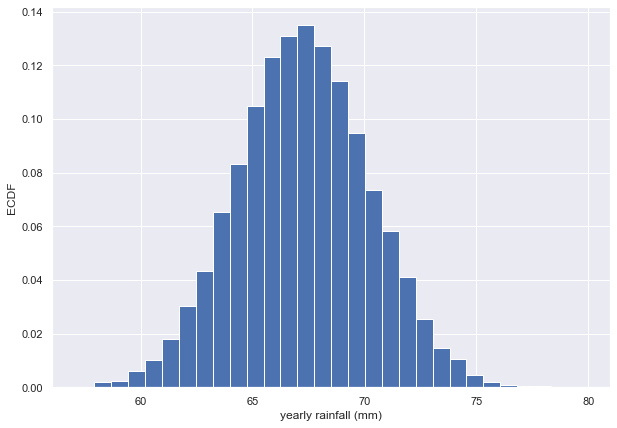

In [11]:
# Plot out the histogram
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(bs_replicates, bins=30, density=True)
plt.xlabel('yearly rainfall (mm)')
plt.ylabel('ECDF')

In [12]:
# Calculate the 95% confidence interval for the rainfall data
conf_int = np.percentile(bs_replicates, [2.5,97.5])
conf_int

array([61.56214072, 73.10131737])

## Create a function that generates many bootstrap replicates from a 1D array

In [17]:
def draw_bs_reps(data, func, size=1):
    """ Draw bootstrap replicates."""
    
    # Initialize array of replicates bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

### Use bootstrap replicates to determine mean of Sheffield annual rainfall

In [18]:
# Use the new function to generate 10,000 bootstrap replicates and compare the SEM of the actual data to the generated Std()
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, size=10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

2.95111124189256
2.9787008642338595


Text(0, 0.5, 'PDF')

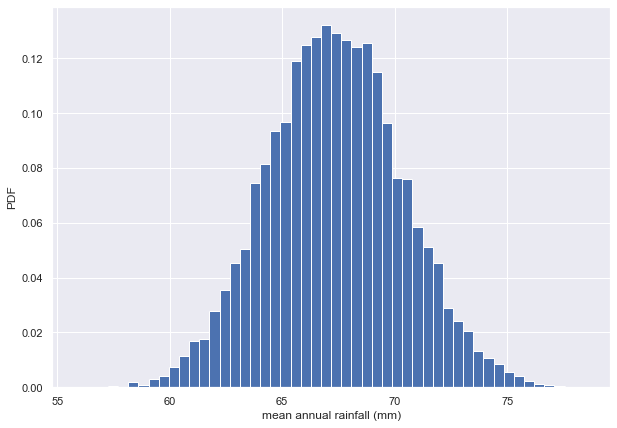

In [20]:
# Make a histogram of the results
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(bs_replicates, bins=50, density=True)
plt.xlabel('mean annual rainfall (mm)')
plt.ylabel('PDF')

### Use bootstrap replicates to determine variance of Sheffield annual rainfall

In [24]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates / 100

Text(0, 0.5, 'PDF')

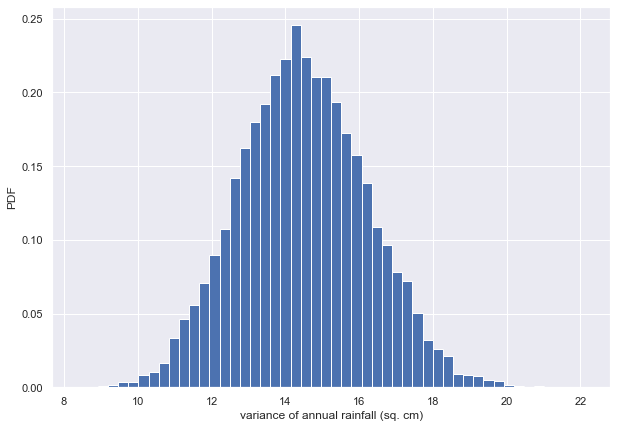

In [27]:
# Make a histogram of the results
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(bs_replicates, bins=50, density=True)
plt.xlabel('variance of annual rainfall (sq. cm)')
plt.ylabel('PDF')

This has a tail on the right hand side so it is not normally distributed

In [30]:
# Compute a 95% confidence interval
var_ci = np.percentile(bs_replicates, [2.5,97.5])
var_ci

array([11.22629127, 17.94471786])

## Create a function to do pairs bootstrap

In [33]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

## Create a permutation sample function

In [34]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data2):]

    return perm_sample_1, perm_sample_2

### Visualizing permutation sampling
We will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data of monthly rainfall in June (a dry month) and November (a wet month) to test the null hypothesis that they are identically distributed. We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

#### Write a for loop to generate 50 permutation samples, compute their ECDFs and plot them

In [50]:
# Create two arrays for rain in June and November
# First inspect data to make sure we have June and November for each year
df.head()

,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6,122.1,---
1,1883,2,8,2.8,2,69.8,---
2,1883,3,4.8,-1.6,23,29.6,---
3,1883,4,12.2,3.8,2,74.0,---
4,1883,5,14.7,6.2,0,31.2,---


In [51]:
df.tail()

,yyyy,mm,tmax,tmin,af,rain,sun
1597,2016,2,7.8,2,5,68.6,96.1
1598,2016,3,9.1,2.9,2,87.2,98.6
1599,2016,4,11.6,3.8,1,65.8,154.9
1600,2016,5,16.9,7.9,0,58.2,164.5
1601,2016,6,18.8,11.1,0,130.4,106.5


Looks like 2016 doesn't have November but it does have June. Since we don't want two different size arrays we can drop 2016 and then create the arrays

In [56]:
equal_months = df.query('yyyy < 2016')

In [57]:
rain_june = equal_months.query('mm == 6').rain
rain_november = equal_months.query('mm == 11').rain

In [58]:
print(f"June rain array length: {len(rain_june)}")
print(f"Nov rain array length: {len(rain_november)}")

June rain array length: 133
Nov rain array length: 133


Text(0, 0.5, 'ECDF')

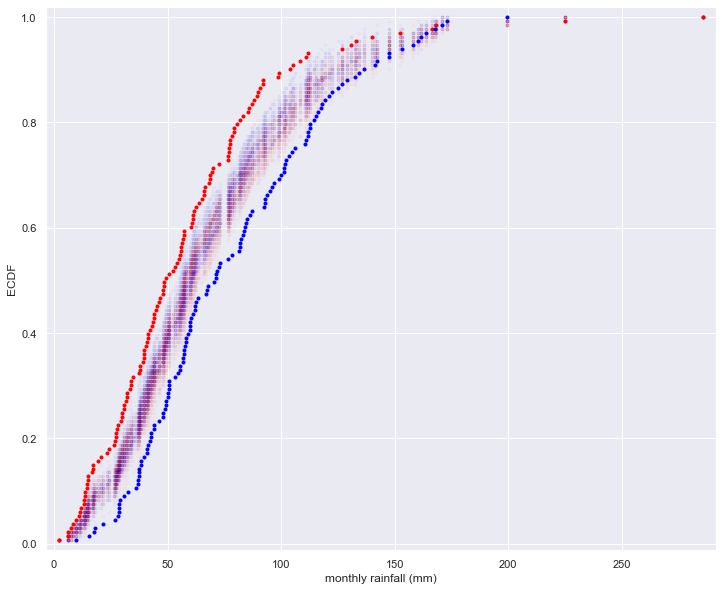

In [67]:
fig, ax = plt.subplots(figsize=(12,10))
for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)
    
# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
plt.xlabel('monthly rainfall (mm)')
plt.ylabel('ECDF')

The permutation sample ECDFs overlap with each other creating a purple haze that doesn't overlap with the actual plotted data shown by the red and blue dots. This suggests that the null hypothesis that June and November have a similar rainfall distribution is disproved.

## Create a function to generate permutation replicates with a passed function as a test statistic

In [70]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

## Plot the rainfall to visualize whether June rainfall looks different than November rainfall

Text(0, 0.5, 'Rainfall (mm)')

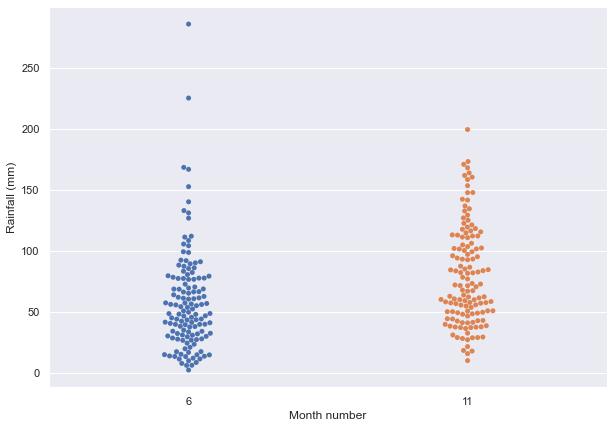

In [78]:
fig, ax = plt.subplots(figsize=(10,7))
sns.swarmplot(x=equal_months.query('mm == 6 or mm == 11').mm, y='rain', data=equal_months)
plt.xlabel('Month number')
plt.ylabel('Rainfall (mm)')

### Make a function to create a test statistic that looks at the difference of the means of the data

In [79]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [81]:
# Compute difference of mean rainfall from rainfall data for June and November: empirical_diff_means
empirical_diff_means = diff_of_means(rain_june, rain_november)
print(f" empirical diff of means: {empirical_diff_means}")

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(rain_june, rain_november,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

 empirical diff of means: -21.1142857142857
p-value = 1.0


## Pipeline for hypothesis testing

* Clearly state the null hypothesis
* Define your test statistic
* Generate many sets of simulated data assuming the null hypothesis is true
* Compute the test statistic for each simulated data set
* The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data


When we only have

In [ ]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)